In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'spam-email:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1422521%2F2355807%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240725%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240725T221847Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da45945dd3a36a50c4696148fee357565193469be0775645fbb1f50072d894e80dcba8133dba6923854e69d5aa7b74561311eefc61855aa149718ef593f9f9f1fb4f08e5ac563abe85b72c89b0f7cef2d5b3df5d89a40b4deaa9070e024377328d8ad313459e8399456429255bc9276148761a3f135a12b1a8d729234f34ec19cabcdb0db4e92b9852552a12ac6b58dd21ced380aeec4f3794f044905d06ef53d4e58d3a3f479be2e32c2a48e3b245420898b45cce556cab8b5e11868a7c87ccb7912a56823580e5de11c503c07a0861c9a07995ea5fac203117c67a5fe88d6d84c5743db0bdcc1350566463911abce6f0c38e703fad04abb0a0239190c70bb4f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 212432 bytes downloaded
Downloaded and uncompressed: spam-email
Data source import complete.


<h1><b><p style="background-image: url(https://images.pexels.com/photos/235985/pexels-photo-235985.jpeg?cs=srgb&dl=pexels-pixabay-235985.jpg&fm=jpg);font-family:calibri;font-size:140%;color:	#fce6d2;text-align:center;border-radius:20px 20px 20px 20px; padding:20px; border:solid 7px #7B3F00; box-shadow: 7px 7px 7px #5C4033; text-shadow: 2px 2px 2px;"> EMAIL SPAM CLASSIFICATION </p></b></h1>

**NOTEBOOK OBJECTIVES**
This notebook aims to:
1. Email text Classification.
2. Spam or NOT.

###1 | META DATA OF DATASET
This dataset contains various emails and it Category whether these are ham or spam.


*   Category : label of email (ham or spam).
*   Message : The age of the patient in years.



###2 | IMPORTING LIBRARIES

In [4]:
!pip install Catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.5 MB/s eta 0:00:00


In [63]:
import pandas as pd
import numpy as np

# for data visualization
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import re
import numpy as np
from bs4 import BeautifulSoup
import nltk

nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
from collections import Counter
import plotly.express as px

# Importing warnings
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalAveragePooling1D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


###3 | IMPORTING DATA

In [6]:
email = pd.read_csv('/kaggle/input/spam-email/spam.csv')
email_style = email.head().style.set_table_styles([
    {"selector": "th", "props": [("color", 'black'), ("background-color", "#8aebf2"),('font-weight','bold')]}])
email_style

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


###4 | SUMMARY STATISTICS

In [7]:
email.isnull().sum()

Category    0
Message     0
dtype: int64

In [8]:
email.duplicated().sum()

415

In [9]:
email.drop_duplicates(inplace=True)
email.duplicated().sum()

0

###5 | VISUALIZATION

In [10]:
df = email.groupby('Category').size()
colors = ['#32a0a8', '#599173']
fig = go.Figure(data=[go.Pie(labels=df.index, values=df.values, textinfo ='label+percent', pull=[0.2,0],
                             marker=dict(colors=colors, line=dict(color='black', width=2)))])
fig.update_layout(paper_bgcolor='#dff2ef', plot_bgcolor='#dff2ef', title = 'Distribution of Spam and Ham Email',
                  width=700, height=600, title_x=0.5, title_font_family="Times New Roman", title_font_color="#191e1f",
                  title_font_size=30, font_family="Times New Roman", font_size=15)
fig.show()

###6 | WORD CLOUD

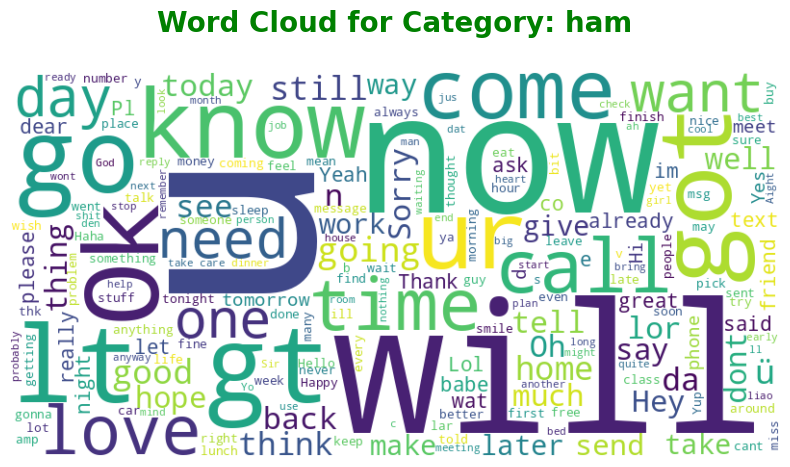

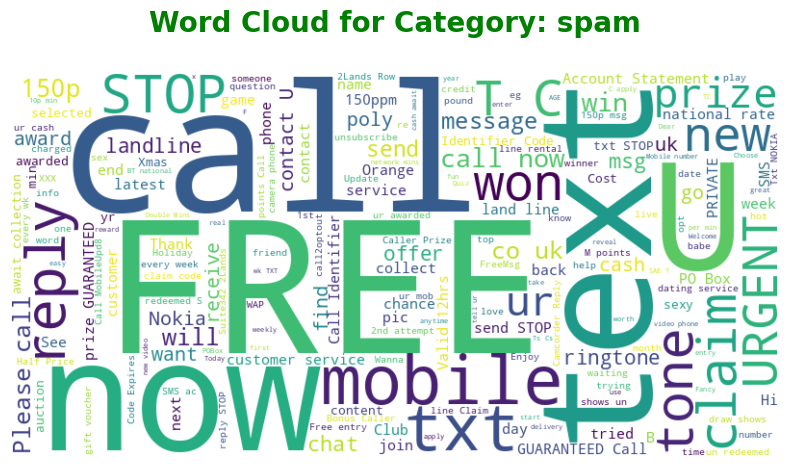

In [11]:
for category in email['Category'].unique():
    # Filter the DataFrame for the current category
    cloud_data = email[email['Category'] == category]

    # Concatenate all text data for the current category
    text = ' '.join(cloud_data['Message'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear', cmap='viridis')
    plt.title(f'Word Cloud for Category: {category}\n', fontsize=20, fontweight='bold', color='green')
    plt.axis('off')
    plt.show()

###7 | WORD, CHARS, SENTENCE COUNTS

In [12]:
email['No of Chars'] = email['Message'].str.len()
email['No of Words'] = email['Message'].apply(lambda x: len(word_tokenize(x)))
email['No of Sentences'] = email['Message'].apply(lambda x: len(sent_tokenize(x)))
email.head()

,Category,Message,No of Chars,No of Words,No of Sentences
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


###8 | SUMMARY DESCRIPTION OF HAM & SPAM MESSAGES

In [13]:
email[email['Category'] == 'ham'].describe()

,No of Chars,No of Words,No of Sentences
count,4516.000000,4516.000000,4516.000000
mean,70.869353,17.267715,1.827724
std,56.708301,13.588065,1.394338
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,53.000000,13.000000,1.000000
75%,91.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [14]:
email[email['Category'] == 'spam'].describe()

,No of Chars,No of Words,No of Sentences
count,641.000000,641.000000,641.000000
mean,137.118565,27.667707,2.970359
std,30.399707,7.103501,1.485575
min,7.000000,2.000000,1.000000
25%,130.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


###9 | TEXT PRE-PROCESSING

####9.1 | LOWER CASING

In [15]:
email['Message'] = email['Message'].apply(lambda x: x.lower())

####9.2 | HTML TAG REMOVER

In [16]:
def html_tag_remover(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
email['Message'] = email['Message'].apply(lambda x: html_tag_remover(x))

####9.3 | REMOVING EXTRA SPACES

In [17]:
email['Message'] = email['Message'].str.strip()

####9.4 | REMOVING EMOJIS

In [23]:
!pip install Emoji
import emoji

In [24]:
def emoji_remover(text):
    return emoji.demojize(text)

email['Message'] = email['Message'].apply(lambda x: emoji_remover(x))

####9.5 | REMOVING SPECIAL CHARACTERS

In [25]:
def remove_special_characters(text):
    # Define the pattern to match special characters
    pattern = r'[@#%&*^$£!()-_+={}\[\]:;<>,.?\/\\\'"`~]'  # Matches any character that is not alphanumeric or whitespace

    # Replace special characters with an empty string
    clean_text = re.sub(pattern, '', text)

    return clean_text

# Apply the function to the 'Message' column
email['Message'] = email['Message'].apply(remove_special_characters)

####9.6 | REMOVING NUMERIC VALUES

In [26]:
def remove_numeric(text):
    return re.sub(r'\d+', '', text)

# Apply the function to the "Message" column
email['Message'] = email['Message'].apply(remove_numeric)

####9.7 | REMOVING CHAT WORDS

In [27]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
"AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [28]:
# Function to replace chat words with their full forms
def chat_conversation(text):
    words = text.split()
    for i, w in enumerate(words):
        if w.upper() in chat_words:
            words[i] = chat_words[w.upper()]
        else:
            words[i] = w
    return ' '.join(words)

# Apply replace_chat_words function to 'Text' column
email['Message'] = email['Message'].apply(chat_conversation)

####9.8 | REMOVING STOP WORDS

In [33]:
# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to remove stop words from text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply remove_stopwords function to 'Text' column
email['Message'] = email['Message'].apply(remove_stopwords)
email.head()

,Category,Message,No of Chars,No of Words,No of Sentences
0,ham,go jurong point crazy available bugis n great ...,111,24,2
1,ham,ok lar joking wif oni,29,8,2
2,spam,free entry wkly comp win fa cup final tkts st ...,155,37,2
3,ham,dun say early hor c already say,49,13,1
4,ham,nah dont think goes usf lives around though,61,15,1


###10 | VISUALIZING FREQUENCY OF HAM & SPAM WORDS

In [34]:
# Function to tokenize and filter stopwords
def filter_stopwords(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word not in stop_words]

email1 = email[email['Category']=='ham']

# Apply the function to your text column
email1['stopwords'] = email1['Message'].apply(filter_stopwords)

# Flatten list of lists and count frequencies
stopword_list = [word for sublist in email1['stopwords'] for word in sublist]
stopword_freq = Counter(stopword_list)

# # Convert the frequency dictionary to a DataFrame
stopword_df = pd.DataFrame(stopword_freq.items(), columns=['Stopword', 'Frequency']).sort_values(by='Frequency', ascending=False)

fig = px.bar(stopword_df[:10] , x = 'Stopword', y = 'Frequency',text = 'Frequency', color='Stopword',
             color_discrete_sequence=px.colors.sequential.PuRd,
             title = 'Rank of Ham Terms',
             template = "simple_white"
              )

fig.update_layout(paper_bgcolor='#dff2ef', plot_bgcolor='#dff2ef', title='Rank Of Ham Words',
                  title_x=0.5, font_color='black', font_family='Arial Black',font_size = 16,
                  xaxis_title = 'Term', xaxis=dict(showgrid=False, title=dict(font=dict(size=16, color='black',
                                                                                        family='Arial black'))),
                  yaxis=dict(showgrid=False,title=dict(font=dict(size=16, color='black', family='Arial black')))
                  )

fig.update_traces(textposition='inside',
                  textfont_size=11, marker_line_width=2, marker_line_color='black', opacity=0.8)
fig.show()

In [35]:
email2 = email[email['Category']=='spam']

# Apply the function to your text column
email2['stopwords'] = email2['Message'].apply(filter_stopwords)

# Flatten list of lists and count frequencies
stopword_list = [word for sublist in email2['stopwords'] for word in sublist]
stopword_freq = Counter(stopword_list)

# # Convert the frequency dictionary to a DataFrame
stopword_df = pd.DataFrame(stopword_freq.items(), columns=['Stopword', 'Frequency']).sort_values(by='Frequency', ascending=False)

fig = px.bar(stopword_df[:10] , x = 'Stopword', y = 'Frequency',text = 'Frequency', color='Stopword',
             color_discrete_sequence=px.colors.sequential.PuBuGn,
             title = 'Rank of Spam Terms',
             template = "simple_white"
              )

fig.update_layout(paper_bgcolor='#dff2ef', plot_bgcolor='#dff2ef', title='Rank Of Spam Words',
                  title_x=0.5, font_color='black', font_family='Arial Black',font_size = 16,
                  xaxis_title = 'Term', xaxis=dict(showgrid=False, title=dict(font=dict(size=16, color='black',
                                                                                        family='Arial black'))),
                  yaxis=dict(showgrid=False,title=dict(font=dict(size=16, color='black', family='Arial black')))
                  )

fig.update_traces(textposition='inside',
                  textfont_size=11, marker_line_width=2, marker_line_color='black', opacity=0.8)
fig.show()

###11 | LEMMETIZATION

In [44]:
# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize text
def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Apply the function to the text column
email['Message'] = email['Message'].apply(lemmatize_text)

###12 | TEXT REPRESENTAION / VECTORIZATION

In [45]:
# Create an instance of CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2,2))

# Fit the model and transform the corpus into vectors
X = vectorizer.fit_transform(email['Message']).toarray().astype(float)

# Get the feature names (vocabulary)
feature_names = vectorizer.get_feature_names_out()

###13 | TF-IDF TRANSFORMER

In [46]:
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

###14 | LABEL ENCODING

In [47]:
y = email['Category']
le = LabelEncoder()
y = le.fit_transform(y)

###15 | SPLITTING DATA

In [48]:
# Train Test Split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 8888)

###16 | MODELS INSTANTIATION

In [49]:
logreg = LogisticRegression(C=0.1, solver='liblinear', max_iter=500, random_state=8888)
mnb = MultinomialNB(alpha=0.1)
svm = SVC(C=10.0, kernel='rbf', gamma='auto', probability=True, random_state=8888)
rf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10, random_state=8888)
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=8888)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=8888)
lgbm = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=8888)
catboost = CatBoostClassifier(random_state=8888, logging_level='Silent')
xgbr = XGBClassifier(objective='binary:hinge',random_state=8888)

###17 | MODELS FITTING

In [50]:
logreg.fit(X_train, y_train)
mnb.fit(X_train, y_train)
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)
dt.fit(X_train, y_train)
gb.fit(X_train, y_train)
catboost.fit(X_train, y_train)
xgbr.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='binary:hinge', ...)

In [51]:
classifiers = []
classifiers.append(logreg)
classifiers.append(mnb)
classifiers.append(svm)
classifiers.append(rf)
classifiers.append(dt)
classifiers.append(gb)
classifiers.append(xgbr)

model_name = ['Logreg', 'NB Multinomial', 'SVM', 'RandomForest', 'DecisionTree', 'GradientBoost','Catboost', 'XGB']

###18 | METRICS CALCULATION

In [52]:
accuracy_list = []
auc_list=[]
recall_list = []
f1_list = []
precision_list = []

for classifier in classifiers :
    y_pred=classifier.predict(X_test)
    y_pred_proba=classifier.predict_proba(X_test)[:,1]
    accuracy_list.append(accuracy_score(y_test,y_pred))
    auc_list.append(roc_auc_score(y_test, y_pred_proba))
    recall_list.append(recall_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred))

In [53]:
def plot_model_score(model_name, accuracy_list, auc_list, recall_list, f1_list, title):

    fig = go.Figure(data=[
        go.Bar(name='Accuracy', x=model_name, y=np.round(accuracy_list,2), text=np.round(accuracy_list,3), marker_color='#97bad9'),
        go.Bar(name='AUC',x=model_name, y=np.round(auc_list,2), text=np.round(auc_list,3), marker_color= '#bcd6ef'),
        go.Bar(name='Recall',   x=model_name, y=np.round(recall_list,2), text=np.round(recall_list,3), marker_color='#ebcad9'),
        go.Bar(name='F1',       x=model_name, y=np.round(f1_list,2), text=np.round(f1_list,3), marker_color='#d5a6bd'),
        go.Bar(name='Precision',x=model_name, y=np.round(precision_list,2), text=np.round(precision_list,3), marker_color='#d5a6bd')
    ])

    fig.update_layout(template = 'simple_white', title = title, title_x=0.5)
    fig.update_layout(xaxis_title="Models", yaxis_title="Score", font = dict(size=17, family = 'Franklin Gothic'))
    fig.update_layout(yaxis_range=[0,1])
    fig.update_traces(marker_line_width=2, marker_line_color='black')
    fig.show()

###19 | VISUALIZING METRICS

In [54]:
plot_model_score(model_name, accuracy_list, auc_list, recall_list, f1_list,
                 'Accuracy, AUC, Recall Score F1 Score & Precision')

###20 | LSTM MODEL

In [55]:
X1 = email['Message']
y1 = email['Category'].apply(lambda x: 1 if x == 'spam' else 0)

maxlength = max([len(x) for x in X1])

def tokenizer_fit(text, OOV_token):
    tokenizer = Tokenizer(oov_token=OOV_token)
    tokenizer.fit_on_texts(text)
    return tokenizer

tokenizer = tokenizer_fit(X1, '<OOV>')

def sequence_padding(sentence, tokenizer,padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentence)
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlength)
    return padded_sequences

X1 = sequence_padding(X1, tokenizer, 'post', maxlength)

# Splitting the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

word_index = tokenizer.word_index
vocab = len(word_index)

In [56]:
def callbacks(Accuracy, Patience):
   early_stopping_and_checkpoint = [EarlyStopping(monitor=Accuracy, patience=Patience, restore_best_weights=True),
                                 ModelCheckpoint('model.weights.h5', monitor=Accuracy, save_best_only=True,save_weights_only=True)]
   return early_stopping_and_checkpoint

####20.1 | BUILDING LSTM

In [57]:
model = Sequential()

model.add(Embedding(input_dim=vocab+1, output_dim=100, input_length=maxlength,input_shape=(maxlength,)))

model.add(Bidirectional(LSTM(50, kernel_regularizer=tf.keras.regularizers.l2(0.03))))

model.add(Dense(6, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 523, 100)          799900    
                                                                 
 bidirectional (Bidirection  (None, 100)               60400     
 al)                                                             
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 860913 (3.28 MB)
Trainable params: 860913 (3.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


####20.2 | FITTING LSTM

In [58]:
history = model.fit(X_train, y_train, epochs=7, batch_size=8, callbacks=callbacks('accuracy', 1), validation_data=(X_test,y_test))

Epoch 1/7
516/516 [==============================] - 230s 423ms/step - loss: 1.0320 - accuracy: 0.9025 - val_loss: 0.3671 - val_accuracy: 0.8682
Epoch 2/7
516/516 [==============================] - 209s 405ms/step - loss: 0.2152 - accuracy: 0.9535 - val_loss: 0.1491 - val_accuracy: 0.9777
Epoch 3/7
516/516 [==============================] - 209s 406ms/step - loss: 0.0957 - accuracy: 0.9884 - val_loss: 0.1198 - val_accuracy: 0.9690
Epoch 4/7
516/516 [==============================] - 210s 407ms/step - loss: 0.0832 - accuracy: 0.9891 - val_loss: 0.1095 - val_accuracy: 0.9719
Epoch 5/7
516/516 [==============================] - 207s 401ms/step - loss: 0.0551 - accuracy: 0.9939 - val_loss: 0.1102 - val_accuracy: 0.9806
Epoch 6/7
516/516 [==============================] - 208s 403ms/step - loss: 0.0479 - accuracy: 0.9956 - val_loss: 0.1175 - val_accuracy: 0.9641
Epoch 7/7
516/516 [==============================] - 206s 400ms/step - loss: 0.1275 - accuracy: 0.9947 - val_loss: 0.1353 - val_ac

In [59]:
y_pred = np.where(model.predict(X_test)>0.5,1,0)

33/33 [==============================] - 5s 115ms/step


####20.3 | EVALUATING METRICES

In [60]:
LSTM_accuracy = np.round(accuracy_score(y_test, y_pred), 3)
LSTM_AUC = np.round(roc_auc_score(y_test, y_pred),3)
LSTM_recall = np.round(recall_score(y_test, y_pred),3)
LSTM_f1 = np.round(f1_score(y_test, y_pred),3)
LSTM_precision = np.round(precision_score(y_test, y_pred),3)

print("LSTM_Accuracy : ", LSTM_accuracy,"\n")
print("LSTM_AUC : ",LSTM_AUC,"\n")
print("LSTM_Recall : ",LSTM_recall,"\n")
print("LSTM_F1 : ", LSTM_f1,"\n")
print("LSTM_Precision : ", LSTM_precision,"\n")

LSTM_Accuracy :  0.964 

LSTM_AUC :  0.945 

LSTM_Recall :  0.919 

LSTM_F1 :  0.871 

LSTM_Precision :  0.828 



####20.4 | VISUALIZING TRAIN AND TEST LOSS

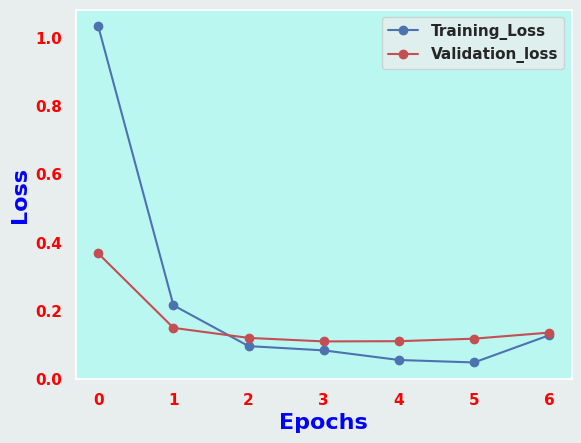

In [61]:
sns.set_theme(rc={'axes.facecolor':'#baf7f1','figure.facecolor':'#e8eded'})
plt.plot(history.history['loss'], label='Training_Loss', marker='o',color='b')
plt.plot(history.history['val_loss'], label='Validation_loss', marker='o',color='r')
plt.xlabel('Epochs',fontsize=16,fontweight='bold',color='blue')
plt.ylabel('Loss',fontsize=16,fontweight='bold',color='blue')
plt.xticks(color='red',weight='bold')
plt.yticks(color='red',weight='bold')
plt.legend(loc='upper right', prop={'weight':'bold'},facecolor='#e8eded')
plt.grid(False)

####20.5 | VISUALIZING TRAIN AND TEST ACCURACY

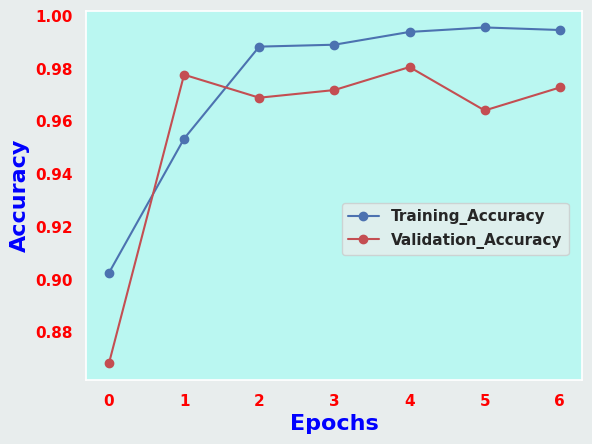

In [62]:
plt.plot(history.history['accuracy'], label='Training_Accuracy', marker='o',color='b')
plt.plot(history.history['val_accuracy'], label='Validation_Accuracy', marker='o',color='r')
plt.xlabel('Epochs',fontsize=16,fontweight='bold',color='blue')
plt.ylabel('Accuracy',fontsize=16,fontweight='bold',color='blue')
plt.xticks(color='red',weight='bold')
plt.yticks(color='red',weight='bold')
plt.legend(bbox_to_anchor=(0.5,0.5), prop={'weight':'bold'},facecolor='#e8eded')
plt.grid(False)